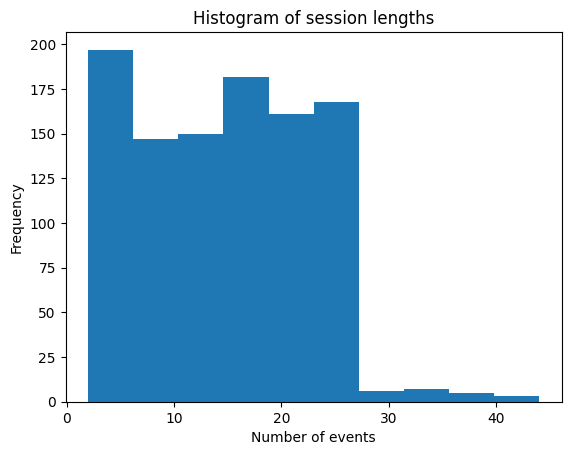

Number of sessions: 1026
Average events per session: 14.688109161793372
Category with highest bounce rate: 18
Country with highest average visit count: Japan
Performer with most visits by category: dance
Recommended items for session ['1', '2', '3', '4']: [131, 155, 15, 7, 61]
Hits: 0/1


In [2]:
#for this code, cotent-based filtering is done for the recommendation based on the assumption of monotonic personal interests
#here jaccard similarity is calculated


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


class Recommender:

    #load data
    def __init__(self, items_path, users_path, events_path):
        """Read the contents of the files and store them in memory."""
        self.items = pd.read_csv(items_path)
        self.users = pd.read_csv(users_path)
        self.events = pd.read_csv(events_path)
        self.events['timestamp'] = pd.to_datetime(self.events['timestamp'], unit='s')  # Convert timestamp from Unix time
        self.events = self.events.sort_values(by=['user_id', 'timestamp'])



    #in train jaccard formula is used to calculate the similarity between items based on their categories

    def train(self):
        """Build an item feature matrix for Jaccard similarity using categories."""
        # category column is assumed here in the items dataset which is used to define categories
        # binary encoding for item categories is created
        self.item_categories = self.items.set_index('item_id')['category'].str.get_dummies()
        self.item_similarity_df = pd.DataFrame(index=self.item_categories.index, columns=self.item_categories.index, dtype=float)
        for item1 in self.item_categories.index:
            for item2 in self.item_categories.index:
                if item1 != item2:
                    #formula for jaccard similarity
                    intersection_size = np.sum(self.item_categories.loc[item1] & self.item_categories.loc[item2])
                    union_size = np.sum(self.item_categories.loc[item1] | self.item_categories.loc[item2])
                    numerator = 2 * intersection_size
                    denominator = len(self.item_categories.loc[item1]) + len(self.item_categories.loc[item2])
                    similarity = numerator / denominator if denominator != 0 else 0
                    self.item_similarity_df.at[item1, item2] = similarity
        # Build popularity data for fallback
        self.popular_items = self.events['item_id'].value_counts().index.tolist()



    # in the below section analysis is done based on the problem in read_me file

    def analyse(self):
          # Step 1: Separate sessions by a gap of >= 8 hours between two events for each user
          self.events['session_gap'] = self.events.groupby('user_id')['timestamp'].diff().dt.total_seconds() >= 8 * 3600
          self.events['session_id'] = self.events.groupby('user_id')['session_gap'].cumsum()
          self.events.drop('session_gap', axis=1, inplace=True)

          # Step 2: Remove duplicate visits of the same item within each session
          self.events = self.events.drop_duplicates(subset=['user_id', 'session_id', 'item_id'])

          # Step 3: Filter out sessions with only a single event
          session_sizes = self.events.groupby(['user_id', 'session_id']).size()
          valid_sessions = session_sizes[session_sizes > 1].index
          self.events = self.events[self.events.set_index(['user_id', 'session_id']).index.isin(valid_sessions)].reset_index(drop=True)

          # Step 4: Calculate statistics
          num_sessions = len(valid_sessions)
          avg_events_per_session = session_sizes[session_sizes > 1].mean()

          # Step 5: Histogram of session lengths for valid sessions (with > 1 event)
          valid_session_sizes = session_sizes[session_sizes > 1]
          plt.hist(valid_session_sizes, bins=10)
          plt.xlabel("Number of events")
          plt.ylabel("Frequency")
          plt.title("Histogram of session lengths")
          plt.show()

          # Step 6: Category with the highest bounce rate (last event in each session)
          last_events = self.events.groupby('session_id').last()
          highest_bounce_category = last_events['item_id'].value_counts().idxmax()

          # Step 7: Country with the highest average visit count per user
          user_country_visits = self.events.groupby('user_id').size().groupby(self.users.set_index('user_id')['country']).mean()
          highest_avg_visit_country = user_country_visits.idxmax()

          # Step 8: Performer with most visits by category (assuming "category" refers to item types in `items`)
          most_visited_performers = self.items.groupby('category')['item_id'].count().idxmax()

          # Output results
          print(f"Number of sessions: {num_sessions}")
          print(f"Average events per session: {avg_events_per_session}")
          print(f"Category with highest bounce rate: {highest_bounce_category}")
          print(f"Country with highest average visit count: {highest_avg_visit_country}")
          print(f"Performer with most visits by category: {most_visited_performers}")




    #Recommended items based on the session's item history using content-based filtering with Jaccard similarity

    def recommend(self, session_item_ids):
        candidate_scores = defaultdict(float)
        # Check similarity for each item in the session
        for session_item in session_item_ids:
            if session_item in self.item_similarity_df.index:
                # Get the items similar to session_item
                similar_items = self.item_similarity_df[session_item].drop(session_item)  # Exclude the item itself
                for candidate_item, similarity_score in similar_items.items():
                    candidate_scores[candidate_item] += similarity_score

        # Sort the items by the similarity score
        sorted_candidates = sorted(candidate_scores.items(), key=lambda x: x[1], reverse=True)
        recommended_items = [item for item, score in sorted_candidates]
        # Fallback to popular items if no recommendations are made
        if not recommended_items:
            for popular_item in self.popular_items:
                if popular_item not in session_item_ids:
                    recommended_items.append(popular_item)


        recommended_items = recommended_items[:5] # 5 item_ids will be returned
        print(f"Recommended items for session {session_item_ids}: {recommended_items}")

        return recommended_items




items_path = './items.csv'
users_path = './users.csv'
events_path = './events.csv'
session_path = './sessions.csv'

# Initialize the Recommender
r = Recommender(items_path, users_path, events_path)

# Train the model
r.train()

# Analyze the dataset
r.analyse()

# Evaluate recommender
with open(session_path, 'r') as f:
    hits = 0
    total = 0
    for row in f.readlines():
        parts = row.split("\t")
        session = parts[0].split(",")
        target_item = row[1]
        recommended = r.recommend(session)
        if target_item in recommended:
            hits +=1
        total+=1
    print("Hits: {}/{}".format(hits, total))

